# Time series analysis on Covid19 deaths : 

this simple project is splitted into three parts :

1. data-collecting & cleaning : 
2. performing SARIMAX : 
3. turning the SARIMAX into a multi-variate ML regression model : 

## 1. data-collecting & cleaning : 

In [1]:
import numpy as np
import pandas as pd
from pandas import Series
from bs4 import BeautifulSoup 
import requests
import re

In [2]:
url = "https://www.worldometers.info/coronavirus/coronavirus-death-toll/"
req = requests.get(url)
soup = BeautifulSoup(req.content, 'html.parser')

In [3]:
deaths = soup.find_all('table')[1]
remove_whitespace = lambda col: col[:len(col) - 1] if col[-1] == ' ' else col

In [4]:
columns = [re.sub(' +', ' ', remove_whitespace(col.text).replace("\n", " ")) for col in deaths.thead.select("tr th")]
data = np.array([[comp.text for comp in row.select("td")[:2]] for row in deaths.tbody.select("tr")])

In [5]:
columns = columns[:2]
columns

['Date', 'Daily Deaths']

In [6]:
series = Series(data[:,1], index = data[:,0])
series.name = "Daily Deaths"
series.index.name = 'Day'
series.index = series.index.str.replace("\xa0", '')
series.index = "2020" + series.index
series.index = pd.to_datetime(series.index, format='%Y %b. %d ', errors = 'coerce')
series.index = series.index.to_period('d')
series.sort_index(ascending = True, inplace=True)
series = series.str.replace(",","")
series = series.astype("float")
series

Day
2020-01-24       16.0
2020-01-25       15.0
2020-01-26       24.0
2020-01-27       26.0
2020-01-28       26.0
               ...   
2020-12-03    12839.0
2020-12-04    12162.0
2020-12-05    10352.0
2020-12-06     7699.0
2020-12-07     8110.0
Freq: D, Name: Daily Deaths, Length: 319, dtype: float64

#### pickling the data : 

In [7]:
series.to_pickle('deaths')
series = pd.read_pickle('deaths')
series

Day
2020-01-24       16.0
2020-01-25       15.0
2020-01-26       24.0
2020-01-27       26.0
2020-01-28       26.0
               ...   
2020-12-03    12839.0
2020-12-04    12162.0
2020-12-05    10352.0
2020-12-06     7699.0
2020-12-07     8110.0
Freq: D, Name: Daily Deaths, Length: 319, dtype: float64

## 2. Performing SARIMAX : 

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
register_matplotlib_converters()

we can start off by plotting our series with a rolling mean and std of 7 days.\
an essential property that our series should possess for the forcasting to work is **stationarity**.\
we say that a time series (TS) **$X_{t}$** is stationary iff :
1. $E[X_{t}] = c $ for all $t > 0$ which means that the expected value of the time series is constant across time.
2. $var[X_{t}] = \sigma^{2} $ which means that the variance is unchanging across time\

as we can observe the series is obviously not stationary and it has a non-linear trend, with a changing variance w.r.t time.

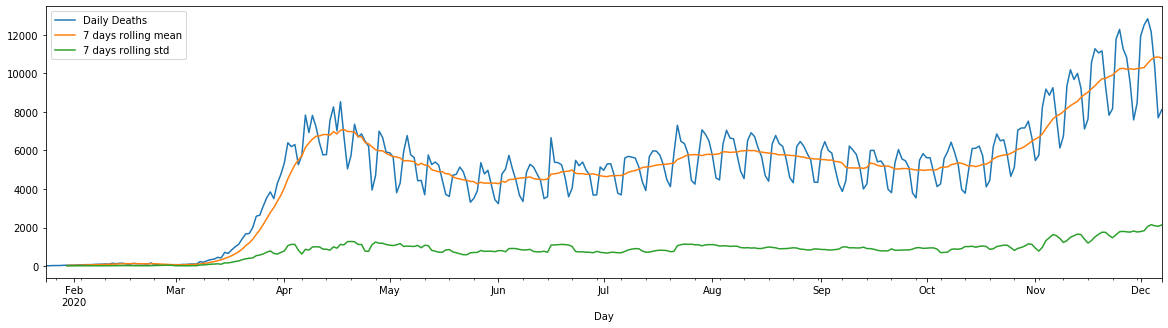

In [9]:
series.plot(figsize=(20,5))
series.rolling(7).mean().plot(label = '7 days rolling mean')
series.rolling(7).std().plot(label = '7 days rolling std')
plt.legend()

one way to test for stationarity is by applying the **dicky fuller tests** which test if the time series is a random walk.\
a random walk of order 1 is represented as : $X_{t} = X_{t-1} + \epsilon_{t}$, with $\epsilon_{t}$ \~ $N(0,s)$\
this is bad because the time series has a unit-root (the coef of the previous value is 1).
as we observe below the TS doesn't pass the dicky fuller test giving a p-value strictly larger than 0.05 making it unable to pass any of the tests even the 10%, thus our TS is non-stationary.

In [10]:
dft = adfuller(series)
print("z (of p-value) : ",dft[0])
print("p-value of 5% test : ",dft[1])
dft[4]

z (of p-value) :  -1.8759768644971007
p-value of 5% test :  0.3434453564143365


{'1%': -3.452045317832011, '5%': -2.871094805558846, '10%': -2.571860921485457}

we make a first attempt to stationaralize the TS by taking the first difference, $X_{t-1} - X_{t}$\
even after taking the first difference the variance is still changing.

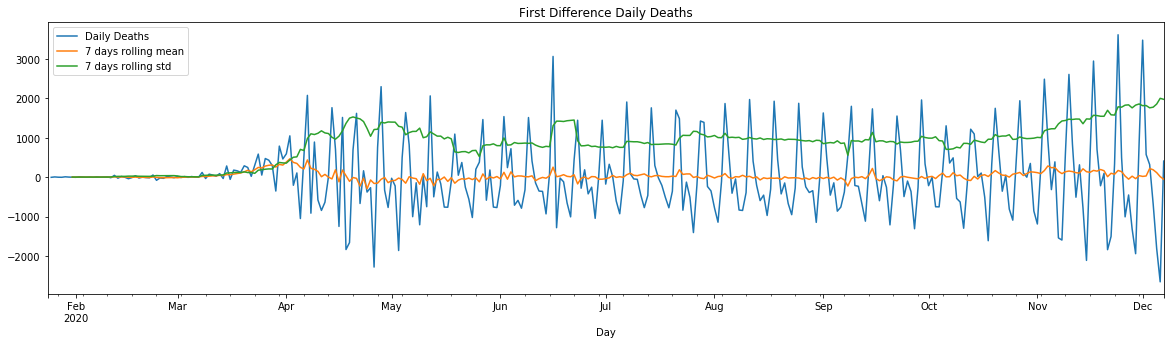

In [11]:
x = (series - series.shift(1))
x.plot(title = 'First Difference Daily Deaths', figsize=(20,5))
x.rolling(7).mean().plot(label = '7 days rolling mean')
x.rolling(7).std().plot(label = '7 days rolling std')
plt.legend()

so let's perform a log transformation to shrink the values of our TS and thus stabilizing the variance.

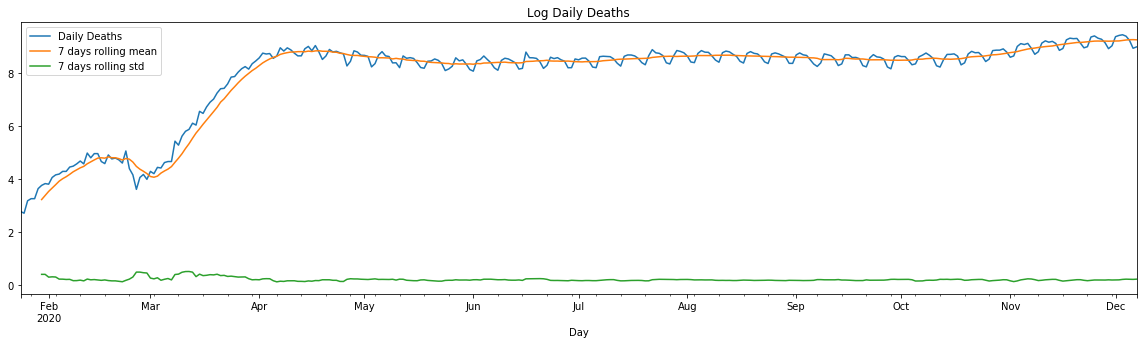

In [12]:
x = np.log(series)
x.plot(title = 'Log Daily Deaths', figsize=(20,5))
x.rolling(7).mean().plot(label = '7 days rolling mean')
x.rolling(7).std().plot(label = '7 days rolling std')
plt.legend()

we can now take the first difference to stationaralize the TS : 

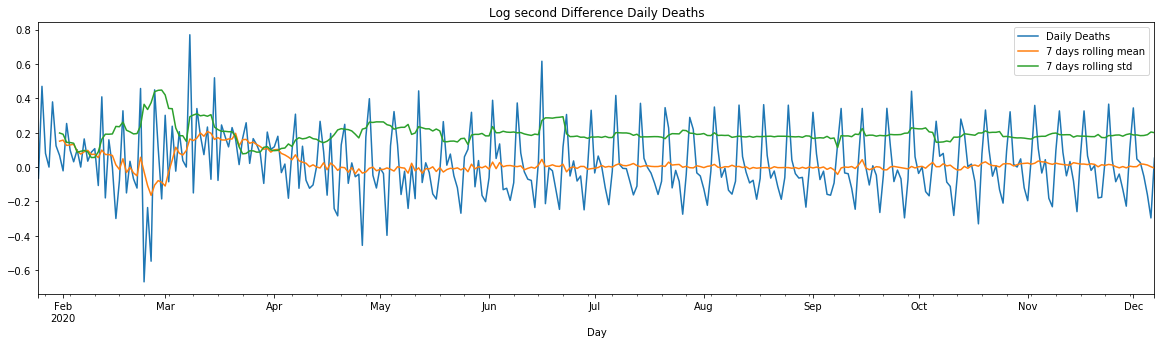

In [13]:
x = (x - x.shift(1)).dropna()
x.plot(title = "Log second Difference Daily Deaths", figsize=(20,5))
x.rolling(7).mean().plot(label = '7 days rolling mean')
x.rolling(7).std().plot(label = '7 days rolling std')
plt.legend()

let's perform the dicky fuller test again, below we see that the TS successfully passes the test for type 1 error equal to 5% and above.\
we observe that by comparing the p-value (lowest val by which the test is passed) to the size of the test $\alpha$

In [14]:
dft = adfuller(x)
print("z (of p-value) : ",dft[0])
print("p-value of 5% test : ",dft[1])
dft[4]

z (of p-value) :  -3.964392466307752
p-value of 5% test :  0.0016088793162686444


{'1%': -3.4523371197407404,
 '5%': -2.871222860740741,
 '10%': -2.571929211111111}

even if the dicky fuller test is passed we r still in need for further analysis.\
the time series is partitioned into three parts, the trend, seasonal and error part.\
by observing the seasonal part plot we can clearly see a seasonal component in our TS which repeats each week.

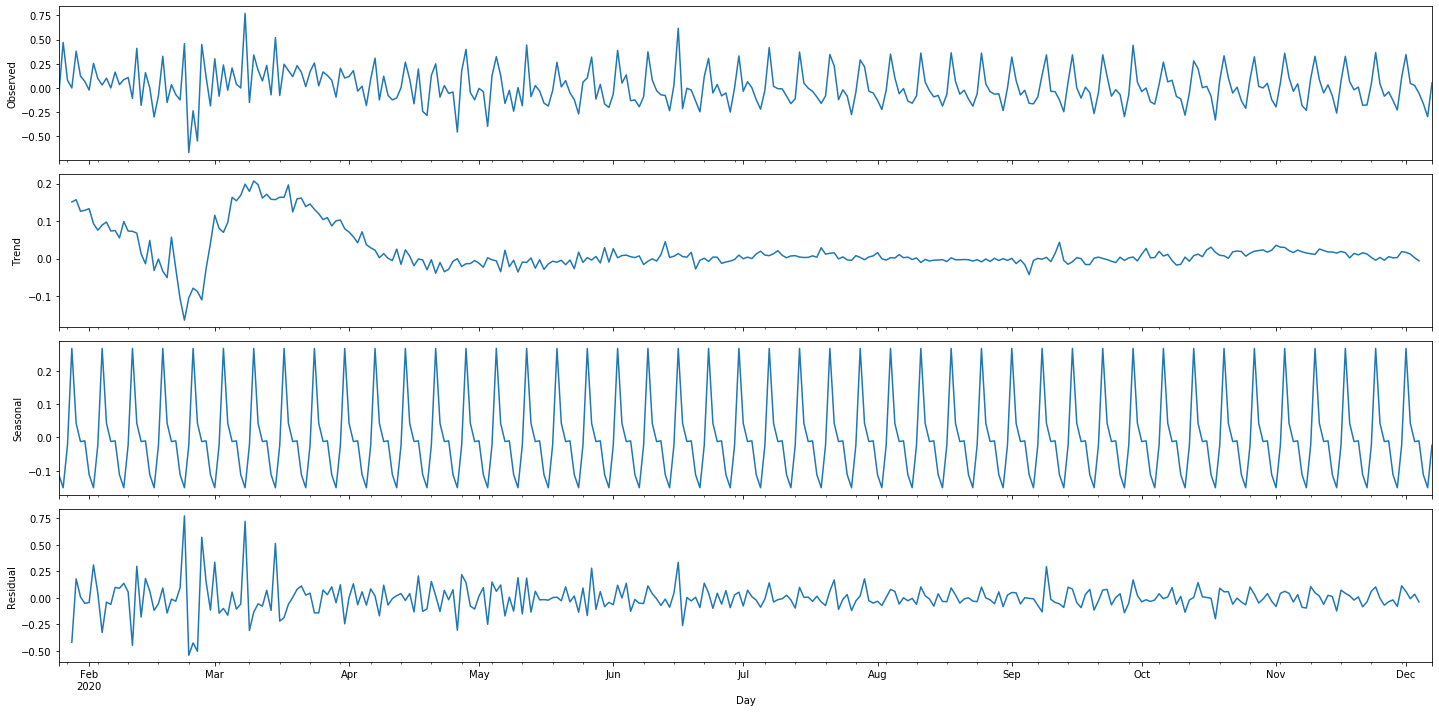

In [15]:
x.interpolate(inplace = True)
x.index=x.index.to_timestamp()
decomp = seasonal_decompose(x)
with mpl.rc_context():
    mpl.rc("figure", figsize=(20,10))
    decomp.plot()

by further observing the ACF plot we can see the seasonality component affect on the lagged correlations.\
our model is possibly an auto regressive model due to the geometric decay of the ACF correlogram, and from the PACF we can see that there are 7 to 9 meaningful lags to consider.

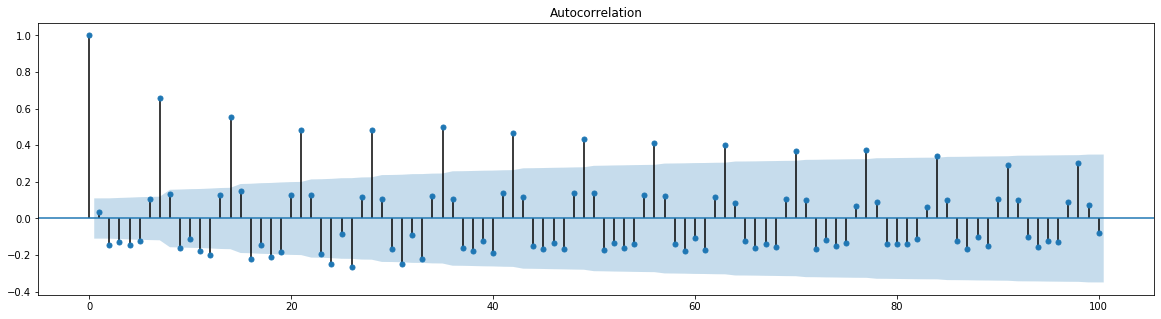

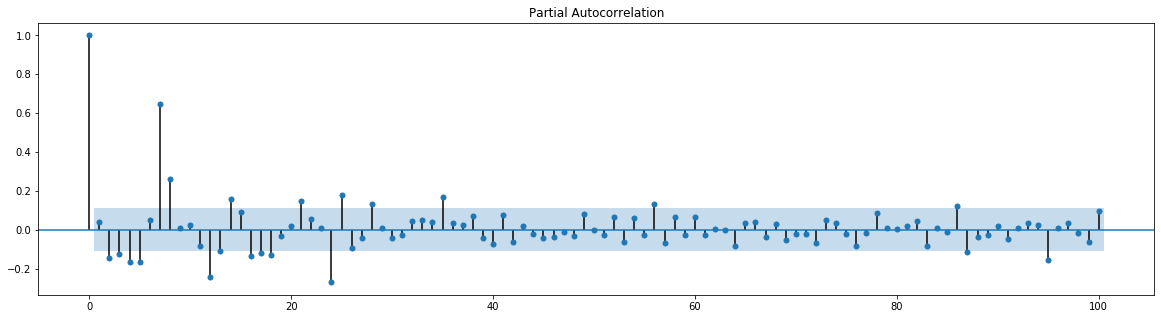

In [16]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(20,5))
    acf_plot = plot_acf(x, lags=100)
    pacf_plot = plot_pacf(x, lags=100)

before jumping to the SARIMAX model we want first to split our data to train and test.

In [17]:
train = x.loc[:'2020-10-31']
test = x.loc['2020-11-01':'2020-12-6']

we are using the SARIMAX model to take into account the seasonal part of our time series, we will use an ARIMA(8,1,0) which means we are using an auto regressive with 8 lags after differcing once.\
the seasonal part is taken into consideration in the seasonal_order, we are considering a 7 days window, just as we have seen in the earlier plots.

In [18]:
sarima_model = SARIMAX(train, order=(8, 1, 0), seasonal_order=(1, 1, 0, 7), enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

                                 Statespace Model Results                                
Dep. Variable:                      Daily Deaths   No. Observations:                  281
Model:             SARIMAX(8, 1, 0)x(1, 1, 0, 7)   Log Likelihood                 128.159
Date:                           Tue, 08 Dec 2020   AIC                           -236.318
Time:                                   06:07:36   BIC                           -200.789
Sample:                               01-25-2020   HQIC                          -222.032
                                    - 10-31-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2136      0.035    -34.358      0.000      -1.283      -1.144
ar.L2         -1.1066      0.046    -24.158

In [19]:
predictions = sarima_fit.predict(start= train.index[-1], end = test.index[-1])
predictions = predictions[1:]
predictions.head()

2020-11-01   -0.251563
2020-11-02    0.073562
2020-11-03    0.344400
2020-11-04    0.061389
2020-11-05   -0.026854
Freq: D, dtype: float64

the residuals below look homoscedasticity (constant variance) and mean of zero.

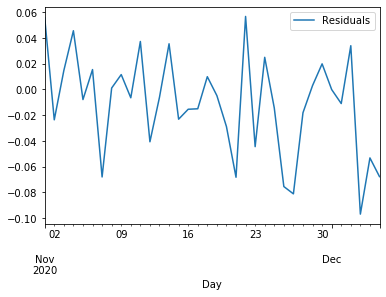

In [20]:
residuals = test - predictions
residuals.plot(label = "Residuals")
plt.legend()

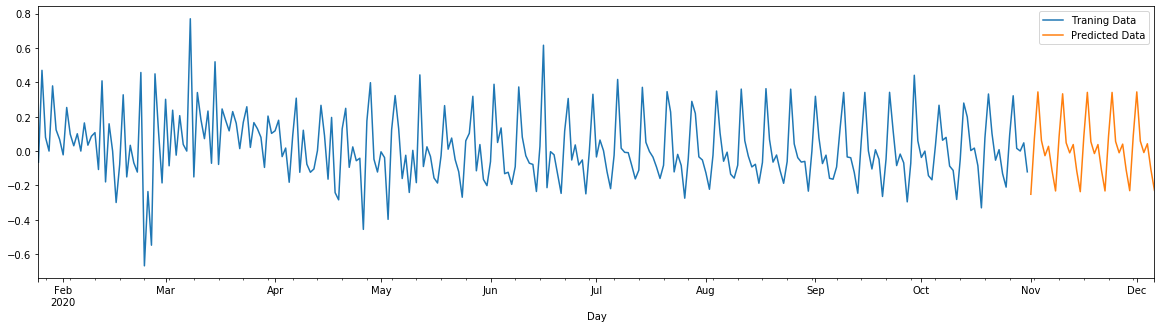

In [21]:
train.plot(label = "Traning Data", figsize=(20,5))
predictions.plot(label = "Predicted Data")
plt.legend()

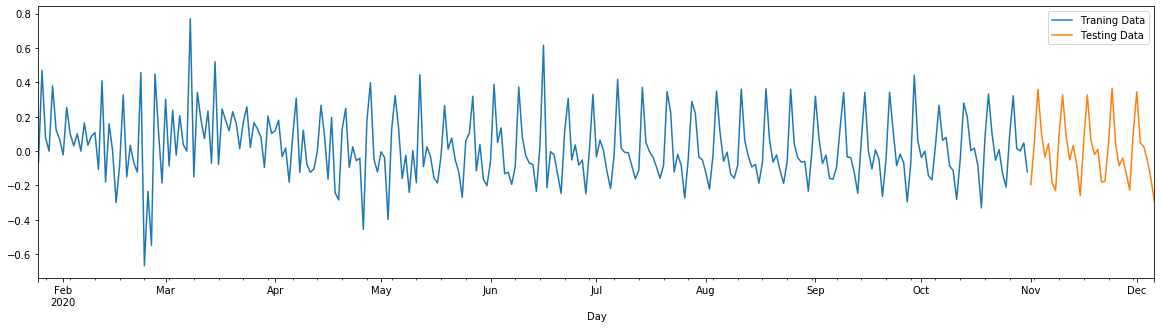

In [22]:
train.plot(label = "Traning Data", figsize=(20,5))
test.plot(label = "Testing Data")
plt.legend()

In [23]:
from sklearn.metrics import r2_score
print('Mean Absolute Error:', round(np.mean(abs(residuals)),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))
print("Accuracy :", r2_score(test, predictions))

Mean Absolute Error: 0.0315
Root Mean Squared Error: 0.04050114466019746
Accuracy : 0.947062542114352


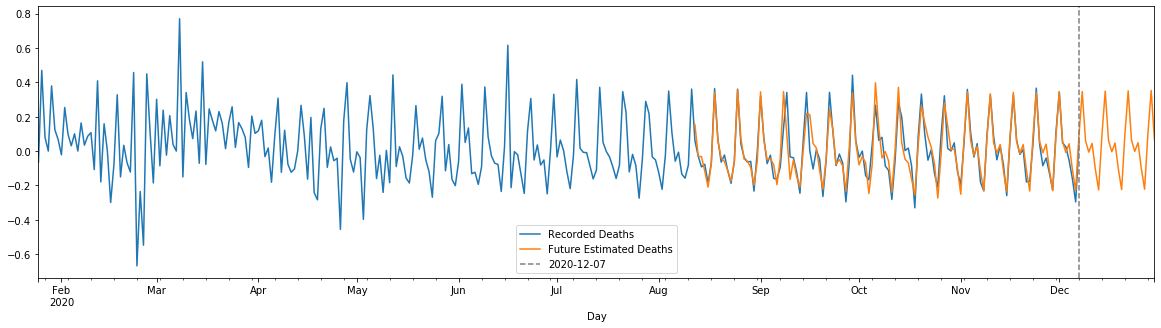

In [24]:
from datetime import datetime
future_deaths = sarima_fit.predict(start= train.index[200] , end = datetime(2020, 12, 30))
x.plot(label = "Recorded Deaths", figsize=(20,5))
future_deaths.plot(label = "Future Estimated Deaths")
plt.axvline(x=datetime(2020, 12, 7), color = 'gray', label = "2020-12-07", linestyle = '--')
plt.legend()

## 3- turning the SARIMAX into a multi-variate ML regression model : 

In [25]:
from skits.feature_extraction import AutoregressiveTransformer, SeasonalTransformer
from skits.preprocessing import DifferenceTransformer, LogTransformer, ReversibleImputer
from sklearn.linear_model import LinearRegression

as in the previous part, here we will focus on the ML side of our forcasting problem, the **skits library** allows us to define a pipeline of transformations, it also allows the reversibility to the original plot unlike our first model using statsmodels.\
below we define a pipeline consisting of log transformation, seasonal shifting by 7 days, imputing then auto-regressive transformation with imputing.

In [26]:
ltr = LogTransformer()
st = SeasonalTransformer(7)
pre_imp = ReversibleImputer()
art = AutoregressiveTransformer(num_lags = 8)
post_imp = ReversibleImputer()
lr  = LinearRegression()

cause all of the transformations are on **y** w.r.t time it is somewhat weird from a machine learning perspective, nevertheless, it can totally make sense when we construct our **X** matrix.

In [27]:
y = series.values
X = y.reshape(-1,1)
print('y : ', y[:10])
print('X : ', X[:10])

y :  [16. 15. 24. 26. 26. 38. 43. 46. 45. 58.]
X :  [[16.]
 [15.]
 [24.]
 [26.]
 [26.]
 [38.]
 [43.]
 [46.]
 [45.]
 [58.]]


In [28]:
X = ltr.fit_transform(X,y)
X = st.fit_transform(X,y)
sy = pre_imp.fit_transform(X,y)
print('y : ', sy[:10])

y :  [[7.90008695]
 [7.90008695]
 [7.90008695]
 [7.90008695]
 [7.90008695]
 [7.90008695]
 [7.90008695]
 [2.83321334]
 [2.77258872]
 [3.21887582]]


we split the y and the X to do forcasting later : 

In [29]:
y_train, y_test = sy[:280], sy[280:]

In [30]:
X = art.fit_transform(sy,sy)
X = post_imp.fit_transform(X,sy)
x_train, x_test = X[:280], X[280:]
print('y : ', sy[:5])
print('X : ', X[:5])

y :  [[7.90008695]
 [7.90008695]
 [7.90008695]
 [7.90008695]
 [7.90008695]]
X :  [[7.88190457 7.88190457 7.88190457 7.88190457 7.88190457 7.88190457
  7.88190457 7.88190457]
 [7.88190457 7.88190457 7.88190457 7.88190457 7.88190457 7.88190457
  7.88190457 7.88190457]
 [7.88190457 7.88190457 7.88190457 7.88190457 7.88190457 7.88190457
  7.88190457 7.88190457]
 [7.88190457 7.88190457 7.88190457 7.88190457 7.88190457 7.88190457
  7.88190457 7.88190457]
 [7.88190457 7.88190457 7.88190457 7.88190457 7.88190457 7.88190457
  7.88190457 7.88190457]]


In [31]:
lr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
p = lr.predict(x_train)
p = pre_imp.inverse_transform(p)
p = st.inverse_transform(p)
p = ltr.inverse_transform(p)
lr.score(x_train,y_train)

0.9530088699813363

In [33]:
ftr = lr.predict(x_test)
ftr = pre_imp.inverse_transform(ftr)
ftr = st.inverse_transform(ftr)
ftr = ltr.inverse_transform(ftr)
lr.score(x_test,y_test)

0.721630733576835

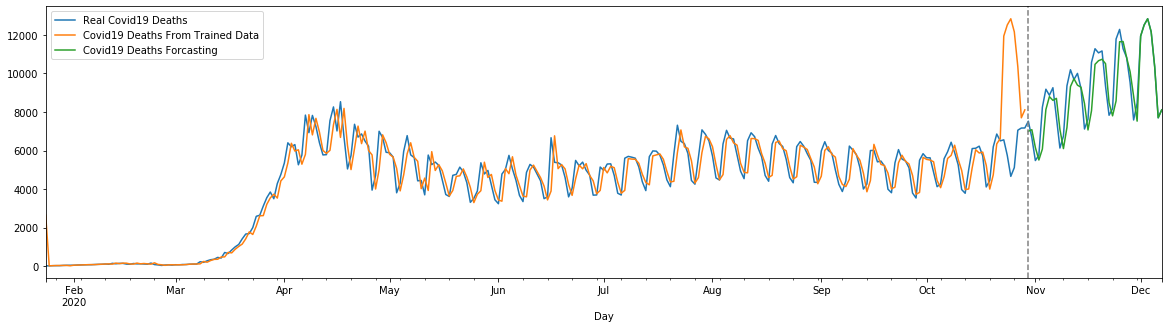

In [34]:
series.plot(label = "Real Covid19 Deaths")
Series(p.flatten(), index = series.index[:280]).plot(figsize=(20,5), label = "Covid19 Deaths From Trained Data")
Series(ftr.flatten(), index = series.index[280:]).plot(figsize=(20,5), label = "Covid19 Deaths Forcasting")
plt.axvline(x=series.index[280], color = 'gray', linestyle = '--')
plt.legend()